In [2]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, learning_curve
import sklearn.metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [3]:
path = '../datas/nlp_results/'
voting_df = pd.read_csv(path+'voting_with_topics.csv')
print('Entries in the DataFrame',voting_df.shape)

#Dropping the useless column
voting_df = voting_df.drop('Unnamed: 0',1)

#Putting numerical values into the columns that should have numerical values
#print(voting_df.columns.values)

num_cols = ['Decision', ' armée', ' asile / immigration', ' assurances', ' budget', ' dunno', ' entreprise/ finance',
           ' environnement', ' famille / enfants', ' imposition', ' politique internationale', ' retraite  ']
voting_df[num_cols] = voting_df[num_cols].apply(pd.to_numeric)

#Inserting the full name at the second position
voting_df.insert(2,'Name', voting_df['FirstName'] + ' ' + voting_df['LastName'])

voting_df.head(3)

Entries in the DataFrame (1713854, 39)


,BillTitle,BusinessNumber,Name,BusinessShortNumber,BusinessTitle,Canton,CantonID,CantonName,Decision,DecisionText,FirstName,ID,IdLegislativePeriod,IdSession,IdVote,Language,LastName,MeaningNo,MeaningYes,ParlGroupCode,ParlGroupColour,ParlGroupName,ParlGroupNameAbbreviation,PersonNumber,RegistrationNumber,Subject,VoteEnd,text,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
0,Arrêté fédéral concernant la contribution de l...,20090055,Chiara Simoneschi-Cortesi,9.055,Réduction des disparités économiques et social...,TI,21,Tessin,7,Die Präsidentin/der Präsident stimmt nicht,Chiara,1183799,48,4811,6392,FR,Simoneschi-Cortesi,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),CEg,#FFFFA500,Groupe conservateur-catholique,Groupe K,511,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
1,Arrêté fédéral concernant la contribution de l...,20090055,Pascale Bruderer Wyss,9.055,Réduction des disparités économiques et social...,AG,1,Aargau,5,Hat nicht teilgenommen,Pascale,1183800,48,4811,6392,FR,Bruderer Wyss,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),S,#FFFF0000,Groupe socialiste,Groupe S,823,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
2,Arrêté fédéral concernant la contribution de l...,20090055,Guy Parmelin,9.055,Réduction des disparités économiques et social...,VD,23,Waadt,5,Hat nicht teilgenommen,Guy,1183801,48,4811,6392,FR,Parmelin,Proposition de la minorité Stamm (ne pas entre...,Proposition de la majorité (entrer en matière),V,#FF006400,"Groupe des Paysans, Artisans et Bourgeois",Groupe B,1108,2652,Entrer en matière,2009-09-07T15:44:26.69,Arrêté fédéral concernant la contribution de l...,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993


In [4]:
voting_df_copy = voting_df.drop_duplicates(['text', 'Name'], keep = 'last')

In [5]:
people = voting_df_copy['Name'].unique()
texts = voting_df_copy['text'].unique()
print("{n} people in the parliament from 2009 to 2015".format(n=people.shape[0]))
voting_df_copy = voting_df_copy.set_index(['Name', 'text'])
voting_df_copy.head()

358 people in the parliament from 2009 to 2015


,,BillTitle,BusinessNumber,BusinessShortNumber,BusinessTitle,Canton,CantonID,CantonName,Decision,DecisionText,FirstName,ID,IdLegislativePeriod,IdSession,IdVote,Language,LastName,MeaningNo,MeaningYes,ParlGroupCode,ParlGroupColour,ParlGroupName,ParlGroupNameAbbreviation,PersonNumber,RegistrationNumber,Subject,VoteEnd,armée,asile / immigration,assurances,budget,dunno,entreprise/ finance,environnement,famille / enfants,imposition,politique internationale,retraite
Name,text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Chiara Simoneschi-Cortesi,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Arrêté fédéral concernant la contribution de l...,20090055,9.055,Réduction des disparités économiques et social...,TI,21,Tessin,7,Die Präsidentin/der Präsident stimmt nicht,Chiara,1184999,48,4811,6397,FR,Simoneschi-Cortesi,NaN,NaN,CEg,#FFFFA500,Groupe conservateur-catholique,Groupe K,511,2657,Vote sur l'ensemble,2009-09-07T16:41:02.057,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
Pascale Bruderer Wyss,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Arrêté fédéral concernant la contribution de l...,20090055,9.055,Réduction des disparités économiques et social...,AG,1,Aargau,1,Ja,Pascale,1185000,48,4811,6397,FR,Bruderer Wyss,NaN,NaN,S,#FFFF0000,Groupe socialiste,Groupe S,823,2657,Vote sur l'ensemble,2009-09-07T16:41:02.057,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
Guy Parmelin,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Arrêté fédéral concernant la contribution de l...,20090055,9.055,Réduction des disparités économiques et social...,VD,23,Waadt,2,Nein,Guy,1185001,48,4811,6397,FR,Parmelin,NaN,NaN,V,#FF006400,"Groupe des Paysans, Artisans et Bourgeois",Groupe B,1108,2657,Vote sur l'ensemble,2009-09-07T16:41:02.057,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
Jean-René Germanier,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Arrêté fédéral concernant la contribution de l...,20090055,9.055,Réduction des disparités économiques et social...,VS,24,Wallis,1,Ja,Jean-René,1185002,48,4811,6397,FR,Germanier,NaN,NaN,RL,#FF00BFFF,Groupe radical-démocratique,Groupe R,1117,2657,Vote sur l'ensemble,2009-09-07T16:41:02.057,0.006995,0.930066,0.006993,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993,0.006993
Edi Engelberger,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Arrêté fédéral concernant la contribution de l...,20090055,9.055,Réduction des disparités économiques et social...,NW,14,Nidwalden,1,Ja,Edi,1185003,48,4811,6397,FR,Engelberger,Na

In the next step, we create a new dataframe with people as indexes, and all the voting Bill / Business title as column. 
The profile matrix contains all the voting decisions of each person (one column per person) for all the subjects (one row per subject), with conventions :
- 0 : Yes
- 1 : No
- 0.5 : did not participate
- -1 : was not part of the parliament at the time of votation

In [6]:
def processVote(vote):
    if vote == 1 or vote == 2:
        return vote-1
    return 0.5

In [7]:
profile_df = pd.DataFrame(data = -1, index = people, columns = texts)
#profile_df.loc[people[0], voting_df_copy.loc[people[0]].index] = voting_df_copy.loc[people[0]].Decision
for p in people:
    profile_df.loc[p, voting_df_copy.loc[p].index] = [processVote(x) for x in voting_df_copy.loc[p].Decision]
profile_df.head()

,Arrêté fédéral concernant la contribution de la Suisse en faveur de la Bulgarie et de la Roumanie au titre de la réduction des disparités économiques et sociales dans l'Union européenne élargie Réduction des disparités économiques et sociales dans l'UE. Contribution de la Suisse en faveur de la Roumanie et de la Bulgarie,Renforcement du Traité sur la non-prolifération des armes nucléaires,Une zone exempte d'armes nucléaires au coeur de l'Europe,Boycott de la liste des terroristes établie par l'ONU,Ratification du Protocole de l'ONU sur les armes à feu et mise en oeuvre de l'instrument Thalmann,Accompagner la construction du nouvel Etat du Kosovo,Renonciation à des projets d'aide au développement menés par l'Etat,Meilleure protection juridique pour les défenseurs de l'environnement,La Suisse doit oeuvrer pour préserver l'unité de la Macédoine,Promouvoir l'Observatoire du Conseil de l'Europe pour le respect des droits de l'homme en Palestine et en Israël,Eclaircissements relatifs au Traité sur la non-prolifération des armes nucléaires,Vérité des coûts au DFAE,Halte au versement des contributions à la Bulgarie,Contribution de la Suisse à la scolarisation d'un million d'enfants africains,Prévention des génocides. Combattre les génocides culturels,"Loi fédérale sur l'examen et le contrôle de la sécurité technique (Loi sur le contrôle de la sécurité, LCS) Examen et contrôle de la sécurité technique. Loi","Loi fédérale sur les installations de transport par conduites de combustibles ou carburants liquides ou gazeux (Loi sur les installations de transport par conduites, LITC) Examen et contrôle de la sécurité technique. Loi",Arrêté fédéral concernant le crédit-cadre de la Confédération pour la réalisation de la 1ère étape de la 3e correction du Rhône (R3) pour la période de 2009 à 2014 Troisième correction du Rhône,Interdiction dès 2012 des ampoules inefficaces,Remplacement des ampoules à filament par des ampoules économiques,"Révision partielle de la LTC. Requête de la Comcom, de la Comco et du Surveillant des prix",Mesures visant à réguler la population des oiseaux piscivores et à indemniser les dégâts causés à la pêche professionnelle,Politique énergétique extérieure de la Suisse,Paysage ferroviaire suisse. Consolidation par les CFF,Certificat énergétique cantonal des bâtiments,Promouvoir l'efficacité énergétique dans le secteur du bâtiment en accordant des avantages en termes d'utilisation des sols pour la construction,Extension de la taxe sur le CO2 aux émissions grises,Les redevances de la SSR doivent être baissées de 20 pour cent,Programmes de réduction des émissions de CO2,Faciliter l'engagement politique,Transports publics en comparaison internationale,Lutte contre les risques naturels,Déchets. Des alternatives à l'incinération,Manifestations aériennes en Suisse. Décréter un moratoire pour préserver le climat,CO2 et gouvernement d'entreprise,Loi fédérale sur l'assurance-maladie (LAMal) (Mesures pour endiguer l'évolution des coûts) LAMal. Mesures pour endiguer l'évolution des coûts,Opération NAVFOR Atalanta. Service d'appui à l'étranger et révision de la LAAM,"Loi fédérale sur l'encouragement de la culture (Loi sur l'encouragement de la culture, LEC) Loi sur l'encouragement de la culture",Sécurité sociale pour les professions avec changements de place fréquents ou engagements de durée limitée,Loi fédérale sur les allégements fiscaux en faveur des familles avec enfants Allègements fiscaux en faveur des familles avec enfants. Loi,Allègements fiscaux en faveur des familles qui gardent elles-mêmes leurs enfants,Passer au système de l'imposition individuelle,"Loi fédérale sur des mesures de stabilisation conjoncturelle temporaire dans les domaines du marché du travail, des technologies de l'information et de la communication et du pouvoir d'achat Mesures de stabilisation conjoncturelle. Loi fédérale limitée dans le temps",Loi fédérale sur l'impôt fédéral direct (LIFD) Progression à froid pour l'impôt fédéral direct. Compensation d

In [8]:
profile_df.to_csv("profileMatrix.csv")
print(profile_df.loc['Brigitta M. Gadient'].values)
profile_df.loc['Duri Campell'].values

[ 0.  1.  1. ..., -1. -1. -1.]


array([-1., -1., -1., ...,  1.,  0.,  0.])

In [8]:
profile_df.loc[people[0]].values

array([ 0.5,  0.5,  0.5, ..., -1. , -1. , -1. ])

In [9]:
def distance(p1, p2):
    d = 0.0
    nCommonVotes = 0
    for i in range(len(p1)):
        if not (p1[i] == -1 or p2[i] == -1):
            nCommonVotes += 1
            d += (p1[i] - p2[i]) * (p1[i] - p2[i])
    if nCommonVotes == 0:
        return -0.001
    return np.sqrt(d / nCommonVotes)

In [10]:
n = people.shape[0]
distanceMatrix = np.zeros((n,n))

for i in range(n):
    if i % 10 == 0:
        print("Compute distances from person " + str(i))
    for j in range(n):
        distanceMatrix[i][j] = distance(profile_df.loc[people[i]].values,
                                        profile_df.loc[people[j]].values)

Compute distances from person 0
Compute distances from person 10
Compute distances from person 20
Compute distances from person 30
Compute distances from person 40
Compute distances from person 50
Compute distances from person 60
Compute distances from person 70
Compute distances from person 80
Compute distances from person 90
Compute distances from person 100
Compute distances from person 110
Compute distances from person 120
Compute distances from person 130
Compute distances from person 140
Compute distances from person 150
Compute distances from person 160
Compute distances from person 170
Compute distances from person 180
Compute distances from person 190
Compute distances from person 200
Compute distances from person 210
Compute distances from person 220
Compute distances from person 230
Compute distances from person 240
Compute distances from person 250
Compute distances from person 260
Compute distances from person 270
Compute distances from person 280
Compute distances from pe

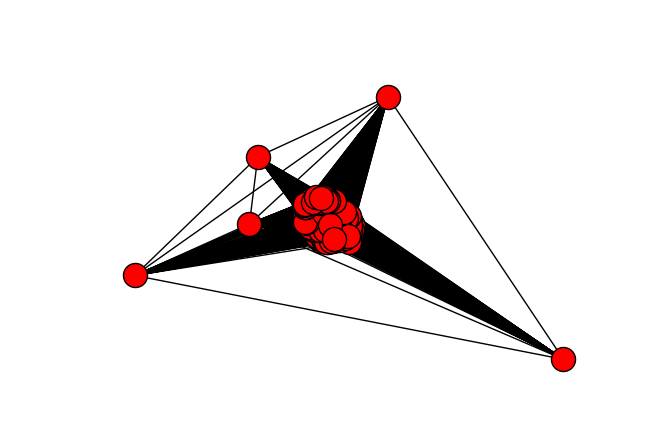

In [11]:
import networkx as nx
G = nx.from_numpy_matrix(distanceMatrix)
nx.draw(G)

import pylab as plt
plt.show()

In [12]:
print("Mean distance : {d}".format(d = np.mean(distanceMatrix)))

Mean distance : 0.5340040030420486


In [13]:
import pandas as pd 
df = pd.DataFrame(distanceMatrix, index = people, columns = people)
df.to_csv("distanceMatrix.csv")
df.head()

,Chiara Simoneschi-Cortesi,Pascale Bruderer Wyss,Guy Parmelin,Jean-René Germanier,Edi Engelberger,Andreas Brönnimann,Jakob Büchler,Eric Voruz,Edith Graf-Litscher,Jacques Neirynck,Walter Wobmann,Laurent Favre,Josef Zisyadis,Hans Killer,Marie-Thérèse Weber-Gobet,Christian Miesch,Antonio Hodgers,Natalie Rickli,Bastien Girod,Felix Müri,Geri Müller,Lukas Reimann,Louis Schelbert,Luzi Stamm,Brigit Wyss,Thomas Hurter,Christian van Singer,Pierre-François Veillon,Daniel Brélaz,Hans Kaufmann,Alec von Graffenried,Jean-Pierre Graber,Katharina Prelicz-Huber,Pirmin Schwander,Adèle Thorens Goumaz,Andreas Aebi,Francine John-Calame,Peter Föhn,Didier Berberat,Attilio Bignasca,Jean-Claude Rennwald,Yves Nidegger,Jean-Charles Rielle,Walter Glur,Ricardo Lumengo,Christoph von Rotz,Eric Nussbaumer,Simon Schenk,Daniel Jositsch,Theophil Pfister,...,Barbara Keller-Inhelder,David Zuberbühler,Min Li Marti,Priska Seiler Graf,Denis de la Reussille,Hans-Ueli Vogt,Lisa Mazzone,Sandra Sollberger,Mauro Tuena,Jonas Fricker,Andreas Glarner,Sibel Arslan,Beat Arnold,Bruno Walliser,Mattea Meyer,Erich Hess,Barbara Steinemann,Franz Ruppen,Claudio Zanetti,Duri Campell,Thomas Burgherr,Laurence Fehlmann Rielle,Franz Grüter,Marcel Dettling,Roger Köppel,Pierre-André Page,Michaël Buffat,Christian Imark,Angelo Barrile,Hans-Ulrich Bigler,Laurent Wehrli,Regine Sauter,Hermann Hess,Philippe Nantermod,Marcel Dobler,Frédéric Borloz,Matthias Samuel Jauslin,Philippe Bauer,Claude Béglé,Géraldine Marchand-Balet,Jacques Nicolet,Marco Chiesa,Thomas Ammann,Andrea Gmür-Schönenberger,Jean-Luc Addor,Manfred Bühler,Tim Guldimann,Christoph Eymann,Werner Salzmann,Magdalena Martullo-Blocher
Chiara Simoneschi-Cortesi,0.000000,0.458336,0.609746,0.440706,0.518711,0.626783,0.505388,0.499799,0.492113,0.439109,0.652197,0.503997,0.498996,0.647101,0.501803,0.665746,0.513072,0.651736,0.488635,0.637259,0.513853,0.652505,0.501403,0.640087,0.493944,0.627743,0.502002,0.588991,0.430806,0.636314,0.487196,0.593572,0.515996,0.682268,0.500201,0.584374,0.500802,0.636944,0.428519,0.576520,0.497385,0.617593,0.507567,0.615640,0.495161,0.634578,0.494553,0.641965,0.485132,0.653580,...,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000
Pascale Bruderer Wyss,0.458336,0.000000,0.682856,0.497788,0.590861,0.688270,0.609910,0.379554,0.363349,0.471073,0.704975,0.584889,0.395094,0.706255,0.388436,0.709939,0.402391,0.694798,0.393313,0.688270,0.413215,0.686811,0.400140,0.684177,0.389726,0.673835,0.393313,0.664691,0.388436,0.656643,0.401642,0.669353,0.396109,0.727664,0.357223,0.651736,0.410780,0.685642,0.286109,0.608056,0.373694,0.660147,0.365277,0.664389,0.361966,0.692484,0.373156,0.699834,0.367194,0.711632,...,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000
Guy Parmelin,0.609746,0.682856,0.000000,0.536323,0.526200,0.315147,0.508120,0.780699,0.799681,0.666520,0.304947,0.514436,0.773249,0.275601,0.818133,0.352148,0.792323,0.317957,0.787405,0.296785,0.783860,0.350647,0.808487,0.310797,0.815554,0.292758,0.799952,0.299368,0.685598,0.344910,0.771479,0.292449,0.822780,0.354709,0.778518,0.308948,0.806215,0.369102,0.794060,0.331893,0.818624,0.326719,0.8

In [14]:
#voting_df['ParlGroupName']
groupId = {"Groupe conservateur-catholique" : 1, "Groupe socialiste" : 2, "Groupe des Paysans, Artisans et Bourgeois" : 3,
           "Groupe radical-démocratique" : 4, "Groupe écologiste" : 5, "Groupe BD" : 6, "Groupe vert'libéral" : 7, "Non inscrit" : 8}
GroupPeople_df = voting_df.drop_duplicates(['Name'], keep = 'last')
GroupPeople_df = GroupPeople_df.set_index('Name')
GroupPeople_df['ParlGroupName'] = [groupId[x] for x in GroupPeople_df['ParlGroupName'].values]
GroupPeople_df = GroupPeople_df['ParlGroupName']
#GroupPeople_df['ParlGroupName'] = [groupId[x] for x in GroupPeople_df.values]
GroupPeople_df.to_json('GroupList.json')
GroupPeople_df

#groupId_df = pd.DataFrame.from_dict(groupId, orient='columns')
#groupId_df.to_json('GroupId.json')

ValueError: If using all scalar values, you must pass an index

In [27]:
groupId_inv = {groupId[k] : k for k in groupId}
groupId_inv_df = pd.DataFrame.from_dict(groupId_inv, orient='index')
groupId_inv_df.to_json('GroupId.json')

In [15]:
GroupPeople_df

Name
Didier Berberat                   2
Attilio Bignasca                  3
Jasmin Hutter-Hutter              3
Maurice Chevrier                  1
Rudolf Rechsteiner                2
Hans Widmer                       2
Ruedi Aeschbacher                 1
Walter Donzé                      1
Jean Henri Dunant                 3
Kathrin Amacker-Amann             1
Johann N. Schneider-Ammann        4
Norman Gobbi                      3
André Daguet                      2
Edi Engelberger                   4
Josef Zisyadis                    5
Marie-Thérèse Weber-Gobet         5
Brigit Wyss                       5
Ricardo Lumengo                   8
Katharina Prelicz-Huber           5
Peter Föhn                        3
Jean-Claude Rennwald              2
Jean-Charles Rielle               2
Walter Glur                       3
Thomas Fuchs                      3
Christoph von Rotz                3
Theophil Pfister                  3
André Reymond                     3
Anita Lachenmeier-Thüri

In [16]:
Group_df = pd.DataFrame(index = voting_df_copy['ParlGroupName'].unique())
Group_df['MeanDistance'] = 0.0
Group_df['NumberOfPeople'] = 0# voting_df[voting_df['ParlGroupName'] == Group_df.index].shape[0]
Group_df

,MeanDistance,NumberOfPeople
Groupe conservateur-catholique,0.0,0
Groupe socialiste,0.0,0
"Groupe des Paysans, Artisans et Bourgeois",0.0,0
Groupe radical-démocratique,0.0,0
Groupe écologiste,0.0,0
Groupe BD,0.0,0
Groupe vert'libéral,0.0,0
Non inscrit,0.0,0


In [17]:
# Computes the mean distance from people within peopleGroup (list of string)
def meanDistance(peopleGroup):
    d = 0.0
    nbPairs = 0
    for p1 in peopleGroup:
        for p2 in peopleGroup:
            #print(p1+' '+p2)
            if not (p1 is p2):
                nbPairs += 1
                d += distance(profile_df.loc[p1].values, 
                              profile_df.loc[p2].values)
    return d / nbPairs

In [18]:
Group_df.loc['Groupe conservateur-catholique']

voting_df[voting_df['ParlGroupName'] == 'Groupe conservateur-catholique']['Name'].unique

print(len(list(voting_df[voting_df['ParlGroupName'] == 'Groupe conservateur-catholique']['Name'].unique())))
print(meanDistance(list(voting_df[voting_df['ParlGroupName'] == 'Groupe BD']['Name'].unique())))

for p in Group_df.index:
    print(p)
    #Group_df.loc[p].NumberOfPeople = len(list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique()))
    Group_df.set_value(p, 'NumberOfPeople', len(list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique())))
    print(Group_df.loc[p]['NumberOfPeople'])
    #Group_df.loc[p]['MeanDistance'] = meanDistance(list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique()))
    Group_df.set_value(p, 'MeanDistance', meanDistance(list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique())))
    print(Group_df.loc[p]['MeanDistance'])

60
0.368097216339
Groupe conservateur-catholique
60.0
0.432353759008
Groupe socialiste
73.0
0.286586554856
Groupe des Paysans, Artisans et Bourgeois
110.0
0.312231390035
Groupe radical-démocratique
62.0
0.357707675173
Groupe écologiste
31.0
0.300573046576
Groupe BD
13.0
0.368097216339
Groupe vert'libéral
12.0
0.212931661528
Non inscrit
3.0
0.658869263833


In [19]:
Group_df

,MeanDistance,NumberOfPeople
Groupe conservateur-catholique,0.432354,60
Groupe socialiste,0.286587,73
"Groupe des Paysans, Artisans et Bourgeois",0.312231,110
Groupe radical-démocratique,0.357708,62
Groupe écologiste,0.300573,31
Groupe BD,0.368097,13
Groupe vert'libéral,0.212932,12
Non inscrit,0.658869,3


In [20]:
meanDistance(list(voting_df['Name'].unique()))

0.53549981257439838

We observe that the average distance between all parliament members is 0.53, and that average distance between people belonging to a same partite is always smaller than 0.43, thus it indicates as expected that people belonging to a same partite vote in a similar way.

We then want to observe the difference between each groups. The difference between 2 groups is defined as the sum of all distances between people from one group to people from the other group (see function GroupDistance). 

In [21]:
# Computes the mean distance of people within group1 from one within group2 (lists of string)
def GroupDistance(group1, group2):
    d = 0.0
    nbPairs = 0
    for p1 in group1:
        for p2 in group2:
            nbPairs += 1
            d += distance(profile_df.loc[p1].values, 
                          profile_df.loc[p2].values)
    return d / nbPairs
    

In [22]:
partite = "Groupe socialiste"
for p in Group_df.index:
    #dist = meanDistance(list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique()))
    dist = GroupDistance(list(voting_df[voting_df['ParlGroupName'] == partite]['Name'].unique()),
                        list(voting_df[voting_df['ParlGroupName'] == p]['Name'].unique()))
    print("Mean distance between partite {p1} and {p2} is : {d}".format(
        p1 = partite, p2 = p, d = dist))

Mean distance between partite Groupe socialiste and Groupe conservateur-catholique is : 0.5817700286675297
Mean distance between partite Groupe socialiste and Groupe socialiste is : 0.28266071163852
Mean distance between partite Groupe socialiste and Groupe des Paysans, Artisans et Bourgeois is : 0.735649796887156
Mean distance between partite Groupe socialiste and Groupe radical-démocratique is : 0.6222442185373711
Mean distance between partite Groupe socialiste and Groupe écologiste is : 0.3427793170290125
Mean distance between partite Groupe socialiste and Groupe BD is : 0.6072008576557756
Mean distance between partite Groupe socialiste and Groupe vert'libéral is : 0.5292042482735654
Mean distance between partite Groupe socialiste and Non inscrit is : 0.5559213603539207


We observe that the partite to which the socialist partite is the further from in terms of votation decisions is the "Groupe des Paysans, Artisans et Bourgeois" partite, and the one to which it is the closest is the "Groupe écologiste" partite.

In [23]:
groups = Group_df.index
groupDistance_df = pd.DataFrame(index = groups, columns = groups)

for g1 in groups:
    for g2 in groups:
        groupDistance_df.set_value(g1, g2, GroupDistance(list(voting_df[voting_df['ParlGroupName'] == g1]['Name'].unique()),
                        list(voting_df[voting_df['ParlGroupName'] == g2]['Name'].unique())))

In [24]:
groupDistance_df

,Groupe conservateur-catholique,Groupe socialiste,"Groupe des Paysans, Artisans et Bourgeois",Groupe radical-démocratique,Groupe écologiste,Groupe BD,Groupe vert'libéral,Non inscrit
Groupe conservateur-catholique,0.425148,0.58177,0.563845,0.46633,0.576823,0.465516,0.532611,0.576277
Groupe socialiste,0.58177,0.282661,0.73565,0.622244,0.342779,0.607201,0.529204,0.555921
"Groupe des Paysans, Artisans et Bourgeois",0.563845,0.73565,0.309393,0.51194,0.725468,0.584478,0.702924,0.532291
Groupe radical-démocratique,0.46633,0.622244,0.51194,0.351938,0.610882,0.450815,0.547106,0.575241
Groupe écologiste,0.576823,0.342779,0.725468,0.610882,0.290877,0.604146,0.541158,0.560451
Groupe BD,0.465516,0.607201,0.584478,0.450815,0.604146,0.339782,0.511735,0.596941
Groupe vert'libéral,0.532611,0.529204,0.702924,0.547106,0.541158,0.511735,0.195187,0.625767
Non inscrit,0.576277,0.555921,0.532291,0.575241,0.560451,0.596941,0.625767,0.439246


We now want to detect people that vote very differently from their own groups.

In [28]:

groupId_inv

{1: 'Groupe conservateur-catholique',
 2: 'Groupe socialiste',
 3: 'Groupe des Paysans, Artisans et Bourgeois',
 4: 'Groupe radical-démocratique',
 5: 'Groupe écologiste',
 6: 'Groupe BD',
 7: "Groupe vert'libéral",
 8: 'Non inscrit'}

In [40]:
list(voting_df[voting_df['Name'] == 'Didier Berberat']['Name'].unique())

['Didier Berberat']

In [45]:
GroupPeople_df.index

Index(['Didier Berberat', 'Attilio Bignasca', 'Jasmin Hutter-Hutter',
       'Maurice Chevrier', 'Rudolf Rechsteiner', 'Hans Widmer',
       'Ruedi Aeschbacher', 'Walter Donzé', 'Jean Henri Dunant',
       'Kathrin Amacker-Amann',
       ...
       'Ruth Humbel', 'Toni Brunner', 'Kathy Riklin', 'Adrian Amstutz',
       'Petra Gössi', 'Doris Fiala', 'Jacques Bourgeois', 'Hugues Hiltpold',
       'Walter Müller', 'Christian Wasserfallen'],
      dtype='object', name='Name', length=358)

In [56]:
partite = "Groupe écologiste"
GroupPeople_df[GroupPeople_df == groupId[partite]]

maxDist = 0
furthestPerson = ""
for p in GroupPeople_df[GroupPeople_df == groupId[partite]].index:
    dist = GroupDistance(list(voting_df[voting_df['ParlGroupName'] == partite]['Name'].unique()),
                        list(voting_df[voting_df['Name'] == p]['Name'].unique()))
    if dist > maxDist:
        maxDist = dist
        furthestPerson = p
    print("Mean distance of {person} to its partite {part} : {d}".format(person = p, part = partite, d = dist))

print("The person in partite {part} which is the furthest of the others in terms of voting is : {p}"
     .format(part=partite, p = furthestPerson))

Mean distance of Josef Zisyadis to its partite Groupe écologiste : 0.3216027714754926
Mean distance of Marie-Thérèse Weber-Gobet to its partite Groupe écologiste : 0.28155383675494916
Mean distance of Brigit Wyss to its partite Groupe écologiste : 0.29049570836155897
Mean distance of Katharina Prelicz-Huber to its partite Groupe écologiste : 0.27352194224501597
Mean distance of Anita Lachenmeier-Thüring to its partite Groupe écologiste : 0.26831264541356264
Mean distance of Josef Lang to its partite Groupe écologiste : 0.2788060991564491
Mean distance of Marlies Bänziger to its partite Groupe écologiste : 0.28511984502517235
Mean distance of Therese Frösch to its partite Groupe écologiste : 0.30431742673156836
Mean distance of Franziska Teuscher to its partite Groupe écologiste : 0.34944174764993124
Mean distance of Antonio Hodgers to its partite Groupe écologiste : 0.3403336603681465
Mean distance of Alec von Graffenried to its partite Groupe écologiste : 0.33521735051790247
Mean dist

In [55]:
partite = "Groupe écologiste"
GroupPeople_df[GroupPeople_df == groupId[partite]]

maxDist = 0
furthestPerson = ""
for partite in groupDistance_df.index:
    maxDist = 0
    for p in GroupPeople_df[GroupPeople_df == groupId[partite]].index:
        dist = GroupDistance(list(voting_df[voting_df['ParlGroupName'] == partite]['Name'].unique()),
                            list(voting_df[voting_df['Name'] == p]['Name'].unique()))
        if dist > maxDist:
            maxDist = dist
            furthestPerson = p
            #print("{pers} {d}".format(pers=p, d=dist))
        #print("Mean distance of {person} to its partite {part} : {d}".format(person = p, part = partite, d = dist))

    print("The person in partite {part} which is the furthest of the others in terms of voting is : {p} with distance {d}"
         .format(part=partite, p = furthestPerson, d = maxDist))

The person in partite Groupe conservateur-catholique which is the furthest of the others in terms of voting is : Marianne Streiff-Feller with distance 0.49130259774243185
The person in partite Groupe socialiste which is the furthest of the others in terms of voting is : Rudolf Rechsteiner with distance 0.4151311601142637
The person in partite Groupe des Paysans, Artisans et Bourgeois which is the furthest of the others in terms of voting is : Christoph Blocher with distance 0.4626426800993992
The person in partite Groupe radical-démocratique which is the furthest of the others in terms of voting is : Alain Ribaux with distance 0.5123341921778847
The person in partite Groupe écologiste which is the furthest of the others in terms of voting is : Christine Häsler with distance 0.467679514851459
The person in partite Groupe BD which is the furthest of the others in terms of voting is : Brigitta M. Gadient with distance 0.41935583927482245
The person in partite Groupe vert'libéral which is 